# Importing the Preliminary Required Libraries

In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Data

In [2]:
dataset = pd.read_csv('Context.csv')

In [3]:
dataset.head()

,Text,Context
0,The eternal mystique of Goldman Sachs,Politics
1,Either you don't care enough to actually tell ...,Love
2,I am such an IDIOT.,Heavy Emotion
3,While lifting weights on Friday and doing bent...,Health
4,Something's watching me,Animals


In [4]:
dataset.shape

(31386, 2)

# Setting up the Environment in PyCaret (NLP)

In [5]:
from pycaret.nlp import *

In [6]:
%time exp_nlp = setup(data = dataset, target = 'Text',session_id=21) 

Description,Value
session_id,21
Documents,31386
Vocab Size,17401
Custom Stopwords,False


Wall time: 1min 29s


# Create a Topic Model

In [7]:
%time model_lda = create_model(model='lda', multi_core=True)

Wall time: 50.2 s


In [8]:
print(model_lda)

LdaModel(num_terms=17401, num_topics=4, decay=0.5, chunksize=100)


# Assign a Model

In [9]:
%time lda_results = assign_model(model_lda) 
lda_results.head()

Wall time: 14.8 s


,Text,Context,Topic_0,Topic_1,Topic_2,Topic_3,Dominant_Topic,Perc_Dominant_Topic
0,,Politics,0.250000,0.250000,0.250000,0.250000,Topic 0,0.25
1,care enough actually tell feel dumbass thinkin...,Love,0.007563,0.008091,0.976618,0.007728,Topic 2,0.98
2,,Heavy Emotion,0.250000,0.250000,0.250000,0.250000,Topic 0,0.25
3,lift bent row feel sharp pain lower back would...,Health,0.042888,0.007420,0.356971,0.592722,Topic 3,0.59
4,watch,Animals,0.134552,0.126089,0.614324,0.125035,Topic 2,0.61


# Plot a Model

In [10]:
plot_model()

# Top 100 Bigrams on Entire Corpus

In [11]:
plot_model(plot = 'bigram')

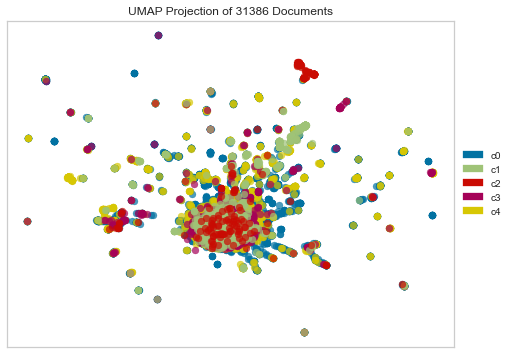

In [12]:
plot_model(model_lda, plot = 'umap')

# Evaluate the model

In [13]:
%time evaluate_model(model_lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

Wall time: 26.4 ms


# Processing NLP model results for Multi Class Text Classification

In [14]:
lda_results.drop(['Text','Dominant_Topic', 'Perc_Dominant_Topic'], axis=1, inplace = True)
lda_results.head()

,Context,Topic_0,Topic_1,Topic_2,Topic_3
0,Politics,0.250000,0.250000,0.250000,0.250000
1,Love,0.007563,0.008091,0.976618,0.007728
2,Heavy Emotion,0.250000,0.250000,0.250000,0.250000
3,Health,0.042888,0.007420,0.356971,0.592722
4,Animals,0.134552,0.126089,0.614324,0.125035


In [15]:
lda_results.shape

(31386, 5)

# Setting up the Environment in PyCaret (Multi Class Claasification)

In [16]:
from pycaret.classification import *
exp_mclf = setup(data = lda_results, target = 'Context', session_id=5,train_size=0.85) 

,Description,Value
0,session_id,5
1,Target,Context
2,Target Type,Multiclass
3,Label Encoded,"Animals: 0, Compliment: 1, Education: 2, Health: 3, Heavy Emotion: 4, Joke: 5, Love: 6, Politics: 7, Religion: 8, Science: 9, Self: 10"
4,Original Data,"(31386, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


# Comparing All Models

In [17]:
%time best= compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2370,0.7118,0.2357,0.2325,0.2298,0.1578,0.1587,1.2290
gbc,Gradient Boosting Classifier,0.2357,0.7111,0.2340,0.2307,0.2236,0.1555,0.1570,14.2770
ada,Ada Boost Classifier,0.2242,0.6661,0.2213,0.2021,0.2001,0.1429,0.1457,0.4800
lr,Logistic Regression,0.2192,0.6912,0.2114,0.1935,0.1867,0.1348,0.1385,1.2430
rf,Random Forest Classifier,0.2185,0.6756,0.2177,0.2201,0.2171,0.1385,0.1390,1.3110
nb,Naive Bayes,0.2167,0.6841,0.2144,0.1732,0.1761,0.1344,0.1382,0.0130
lda,Linear Discriminant Analysis,0.2156,0.6882,0.2066,0.2063,0.1671,0.1301,0.1367,0.0220
et,Extra Trees Classifier,0.2113,0.6611,0.2102,0.2137,0.2103,0.1305,0.1309,2.8520
ridge,Ridge Classifier,0.2067,0.0000,0.1960,0.1413,0.1339,0.1189,0.1295,0.0180
knn,K Neighbors Classifier,0.2028,0.6195,0.2012,0.2073,0.1972,0.1210,0.1223,0.0640


Wall time: 3min 44s


# Create Require Models

In [18]:
%time lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2395,0.7171,0.2363,0.2398,0.2343,0.1590,0.1599
1,0.2391,0.7078,0.2396,0.2333,0.2311,0.1614,0.1623
2,0.2444,0.7156,0.2418,0.2384,0.2374,0.1653,0.1660
3,0.2373,0.7109,0.2377,0.2312,0.2290,0.1592,0.1601
4,0.2343,0.7117,0.2338,0.2290,0.2263,0.1560,0.1571
5,0.2211,0.7121,0.2221,0.2134,0.2123,0.1411,0.1420
6,0.2511,0.7171,0.2476,0.2463,0.2433,0.1722,0.1732
7,0.2369,0.7086,0.2335,0.2353,0.2311,0.1566,0.1574
8,0.2283,0.7040,0.2286,0.2260,0.2224,0.1491,0.1500
9,0.2385,0.7130,0.2361,0.2320,0.2308,0.1580,0.1588


Wall time: 12.9 s


In [19]:
print(lightgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [20]:
%time knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2151,0.6340,0.2135,0.2211,0.2077,0.1345,0.1363
1,0.2028,0.6180,0.1990,0.2082,0.1999,0.1199,0.1206
2,0.2069,0.6258,0.2056,0.2115,0.2056,0.1253,0.1259
3,0.2005,0.6181,0.1976,0.2049,0.1976,0.1168,0.1175
4,0.1972,0.6085,0.1934,0.1971,0.1862,0.1145,0.1164
5,0.1972,0.6224,0.1978,0.2040,0.1917,0.1156,0.1175
6,0.2091,0.6205,0.2064,0.2113,0.1991,0.1281,0.1299
7,0.2031,0.6175,0.2029,0.2122,0.2007,0.1230,0.1241
8,0.1905,0.6083,0.1908,0.1944,0.1850,0.1083,0.1094
9,0.2055,0.6216,0.2052,0.2079,0.1986,0.1237,0.1251


Wall time: 1.39 s


In [21]:
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


# Tuning the Required Models

In [22]:
%time tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2380,0.7202,0.2387,0.2359,0.2282,0.1599,0.1612
1,0.2421,0.7129,0.2396,0.2320,0.2303,0.1647,0.1658
2,0.2436,0.7215,0.2412,0.2346,0.2334,0.1644,0.1652
3,0.2425,0.7193,0.2433,0.2319,0.2298,0.1649,0.1662
4,0.2343,0.7130,0.2342,0.2245,0.2232,0.1558,0.1570
5,0.2286,0.7140,0.2276,0.2208,0.2187,0.1479,0.1488
6,0.2440,0.7174,0.2431,0.2385,0.2341,0.1647,0.1658
7,0.2522,0.7103,0.2503,0.2468,0.2435,0.1740,0.1748
8,0.2265,0.7052,0.2291,0.2201,0.2177,0.1473,0.1483
9,0.2336,0.7134,0.2325,0.2216,0.2227,0.1528,0.1537


Wall time: 2min 27s


In [23]:
%time tuned_knn = tune_model(knn)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2481,0.7023,0.2479,0.2481,0.2443,0.1713,0.1720
1,0.2421,0.6905,0.2367,0.2393,0.2366,0.1626,0.1633
2,0.2324,0.6905,0.2322,0.2233,0.2216,0.1529,0.1541
3,0.2388,0.6852,0.2352,0.2373,0.2349,0.1587,0.1592
4,0.2301,0.6858,0.2268,0.2270,0.2218,0.1501,0.1514
5,0.2211,0.6893,0.2193,0.2153,0.2152,0.1394,0.1399
6,0.2403,0.6949,0.2397,0.2349,0.2307,0.1618,0.1631
7,0.2354,0.6919,0.2353,0.2313,0.2297,0.1575,0.1582
8,0.2291,0.6883,0.2271,0.2271,0.2259,0.1488,0.1492
9,0.2366,0.6910,0.2340,0.2335,0.2319,0.1562,0.1568


Wall time: 8.54 s


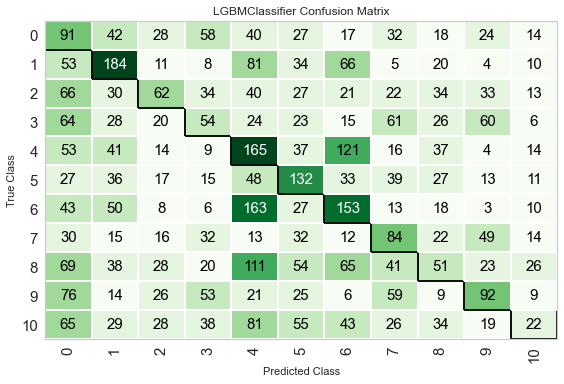

In [24]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

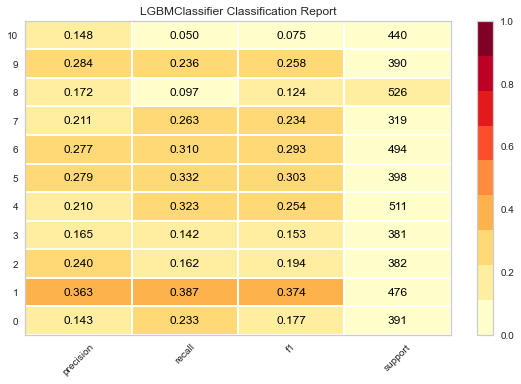

In [25]:
plot_model(tuned_lightgbm, plot = 'class_report')

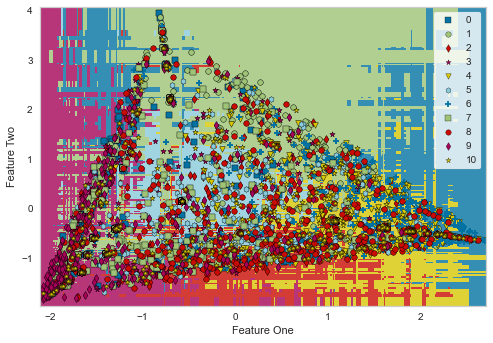

In [26]:
plot_model(tuned_lightgbm, plot='boundary')

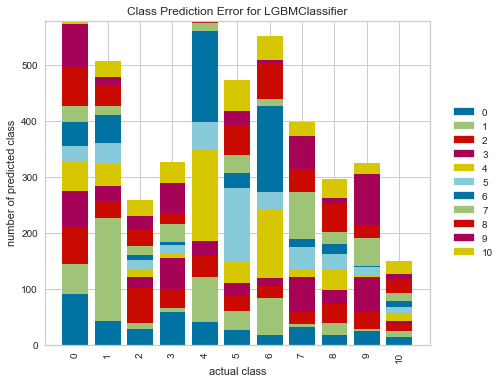

In [27]:
plot_model(tuned_lightgbm, plot = 'error')

# Evaluating the Model

In [28]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [29]:
evaluate_model(tuned_knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Predict on test / hold-out Sample

In [30]:
predict_model(tuned_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.2315,0.7156,0.2303,0.2277,0.2226,0.1532,0.1544


In [31]:
predict_model(tuned_knn);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.2251,0.6884,0.2203,0.2174,0.2153,0.1447,0.1459


# Finalize Model for Deployment

In [32]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [33]:
print(final_lightgbm)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', learning_rate=0.15, max_depth=-1,
               min_child_samples=76, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=40, n_jobs=-1, num_leaves=40, objective=None,
               random_state=5, reg_alpha=1e-06, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


   # FINAL INFERENCE


   # Low Accuracy?

 1. Pycaret, the name itself suggests that it is strong for its Classification and Regression technique.
    (Caret- Classification And Regression Training). It’s a highly efficient model when it comes to perform 
    classification and regression tasks.


2. As far as NLP is concerned, it is just in the intermediate stage. The embedding technique used by Pycaret 
   is  different from rest of the traditional algorithms.

    
3. Another limitation is that, we cant incorporate other embedding technique into this algorithm, 
   so we have to undergo topic modelling as a mandatory step.
    

4. Topic modelling may be helpful in the case of unsupervised learning, to get topics out of raw text. 
   But as far as target modelling is concerned, it acts as a limitation.

    
5. Well, we have to wait for the upcoming NLP version in Pycaret module supports the embedding technique 
   used by other traditional algorithms.
